In [199]:
import pandas as pd
import random as rand
import numpy as np
import math
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Read data
data_beijing = pd.read_csv('Cities/Beijing_labeled.csv')
data_shanghai = pd.read_csv('Cities/Shanghai_labeled.csv')
data_chengdu = pd.read_csv('Cities/Chengdu_labeled.csv')
data_shenyang = pd.read_csv('Cities/Shenyang_labeled.csv')
data_guanzhou = pd.read_csv('Cities/Guangzhou_labeled.csv')

test_data_guanzhou = data_guanzhou
test_data_shanghai = data_shanghai

In [200]:
train_data = data_beijing.append(data_shenyang, ignore_index = True)

X_train = train_data.loc[:, train_data.columns != 'PM_HIGH']
Y_train = train_data.loc[:,"PM_HIGH"]

X_test_guangzhou = test_data_guanzhou.loc[:, test_data_guanzhou.columns != 'PM_HIGH']
Y_test_guangzhou = test_data_guanzhou.loc[:,"PM_HIGH"]

X_test_shanghai = test_data_shanghai.loc[:, test_data_shanghai.columns != 'PM_HIGH']
Y_test_shanghai = test_data_shanghai.loc[:,"PM_HIGH"]


**Undersampling training data**\
In our training data set the majority class for the target variable is 0. Here, we use undersampling to create a balanced data set. We get a data set with 1564 rows. 

In [201]:
# Get indices of all 'ones' from training data
ones_inds = train_data.loc[train_data['PM_HIGH'] == 1].index.to_list()
number_of_ones = len(ones_inds)

# Get indices of all 'zeros' from training data 
zeros_inds = train_data.loc[train_data['PM_HIGH'] == 0].index.tolist()

# Select a random subset of 'zeros', the same number as the number of 'ones' 
random_zeros = rand.sample(zeros_inds, number_of_ones)

# Combine indices of all of the original 'ones', and the selected 'zeros'
undersampling_inds = ones_inds + random_zeros
undersampled_data = train_data.iloc[undersampling_inds]

# Shuffle the data
undersampled_data = undersampled_data.sample(frac=1)
 
# Split into X and Y
X_train_undersampled = undersampled_data.loc[:, undersampled_data.columns != 'PM_HIGH']
Y_train_undersampled = undersampled_data.loc[:,"PM_HIGH"]

**Oversampling training data**\
In our training data set the majority class for the target variable is 0. Here, we use oversampling to create a balanced data set. We get a data set with 5280 rows. 

In [202]:
# Get all the 'ones' from the training data
ones =  train_data.loc[train_data['PM_HIGH'] == 1]
ones_copy = ones.copy()

# Triple the 'ones' we had from the beginning
train_data_extra_ones = train_data.append(ones_copy, ignore_index = True)
train_data_extra_ones = train_data_extra_ones.append(ones_copy, ignore_index = True)

# Get 1858 indices of 'ones' so that we have the same amount of 'ones' as 'zeros'
extra_ones_inds = train_data_extra_ones.loc[train_data_extra_ones['PM_HIGH'] == 1].index.tolist()
rand_extra_ones = rand.sample(extra_ones_inds, 1858)

# Combine indices of all of the original 'ones', 'zeros' and the extra 'ones'
oversampling_inds = ones_inds + zeros_inds + rand_extra_ones
oversampled_data = train_data_extra_ones.iloc[oversampling_inds]

# Shuffle the data
oversampled_data = oversampled_data.sample(frac=1)

# Split into X and Y
X_train_oversampled = oversampled_data.loc[:, oversampled_data.columns != 'PM_HIGH']
Y_train_oversampled = oversampled_data.loc[:,"PM_HIGH"]

**Oversampling the test data**

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Create oversampler
oversample = RandomOverSampler(sampling_strategy='minority')


# Oversample data for both shanghai and guangzhou
X_test_oversampled_shanghai, Y_test_oversampled_shanghai = oversample.fit_resample(X_test_shanghai, Y_test_shanghai)
X_test_oversampled_guangzhou, Y_test_oversampled_guangzhou = oversample.fit_resample(X_test_guangzhou, Y_test_guangzhou)

**Scaling the data**\
The features in the data set are of different magnitude. We are measuring distances, and want all features to be treated equally - all features should have the same impact on the distance calculation. Therefore, we scale the data using the min max scaler. 

In [ ]:
X_train = X_train_oversampled
Y_train = Y_train_oversampled 

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled_shanghai = scaler.transform(X_test_oversampled_shanghai)
X_test_scaled_guangzhou = scaler.transform(X_test_oversampled_guangzhou)

**Create KMeans Classifier** \
Our classifier, implemented with KMeans from sklearn. 

In [205]:
# create model
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import accuracy_score

class KMeansClassifier:

    def __init__(self, k):
        self.k = k
        # The Y-value for each centroid
        self.centroid_y = []
        # The centroid coordinates
        self.centroid_centers = []
    
    def fit(self, X, Y):

        # Fit SKLearns KMeans clustering
        kmeans = KMeans(n_clusters = self.k, n_init='auto')
        kmeans.fit(X)
        
        # Get the centroid centers
        self.centroid_centers = kmeans.cluster_centers_ 

        # Get what datapoints belong to which cluster
        point_belongs_to = kmeans.labels_


        for centroid_i in range(self.k):

            # Indices of all datapoints belonging to centroid i
            index_centroid_i = np.where(point_belongs_to == centroid_i)
            
            # All the Y-values of datapoints in centroid i
            y_values_centroid_i = Y.iloc[index_centroid_i]

            # The most frequent Y-value in centroid i
            most_frequent_y = y_values_centroid_i.value_counts().idxmax()

            self.centroid_y.append(most_frequent_y)
            
    def predict(self, X):
        predictions = []
        for datapoint in X:

            # The index of the closest centroid
            closest_centroid = pairwise_distances_argmin([datapoint], self.centroid_centers)

            # The Y-value of the the closest centroid
            y_value = self.centroid_y[closest_centroid[0]]
            predictions.append(y_value)
        
        return predictions
        

    def score(self, x, y):
        predictions  = self.predict(x)

        # Calculate accuary
        acc = accuracy_score(y, predictions)
        return acc

**Cross-validation**\
Using cross-validation with 5 folds to identify the number of clusters that gives the best performance on our training data. 

In [206]:
from sklearn.metrics import f1_score

# Number of folds
k = 5
kfold = KFold(k, shuffle=False)

plot_acc_scores = []

for i in range(1,25):

    clf = KMeansClassifier(i)
    acc_scores = []
    f1_scores = []

    for train_index, test_index in kfold.split(X_train_scaled):

        # Split into train and test sets based on the KFold
        X_train, X_test = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        clf.fit(X_train, y_train)
        predicted_values = clf.predict(X_test)
        
        acc = accuracy_score(y_test, predicted_values)
        acc_scores.append(acc)
        avg_acc_score = sum(acc_scores)/k

        f1 = f1_score(y_test, predicted_values)
        f1_scores.append(f1)
        avg_f1_score = sum(f1_scores)/k
    
    plot_acc_scores.append(avg_acc_score)
    
    print('Accuracy of each fold: {}'.format(acc_scores))
    print('f1 score of each fold: {}'.format(f1_scores))
    print('Avg accuracy: {} for k = {}'.format(avg_acc_score, i))
    print('Avg f1 score: {} for k = {}'.format(avg_f1_score, i))
    print('\n')

Accuracy of each fold: [0.5499474237644585, 0.5709779179810726, 0.5720294426919033, 0.5621052631578948, 0.5368421052631579]
f1 score of each fold: [0.7096336499321574, 0.7269076305220884, 0.7277591973244147, 0.7196765498652291, 0.6986301369863014]
Avg accuracy: 0.5583804305716974 for k = 1
Avg f1 score: 0.7165214329260382 for k = 1


Accuracy of each fold: [0.5930599369085173, 0.40904311251314407, 0.61198738170347, 0.5978947368421053, 0.42105263157894735]
f1 score of each fold: [0.5251533742331288, 0.5339966832504145, 0.6392961876832844, 0.6225296442687748, 0.4488977955911823]
Avg accuracy: 0.5266075599092368 for k = 2
Avg f1 score: 0.553974737005357 for k = 2


Accuracy of each fold: [0.6466876971608833, 0.49631966351209256, 0.40904311251314407, 0.38526315789473686, 0.5168421052631579]
f1 score of each fold: [0.7345971563981043, 0.5317693059628543, 0.5277310924369747, 0.5008547008547009, 0.6066838046272494]
Avg accuracy: 0.49083114726880295 for k = 3
Avg f1 score: 0.5803272120559766 f

From performing the cross-validation, we selected 5 as the number of clusters to use. 

Here, we are training the classifier with the selected number of clusters and calculating first the accuracy, and then the f1 score. 

In [207]:
clf = KMeansClassifier(5)

# Shanghai
clf.fit(X_train_scaled, Y_train)
score = clf.score(X_test_scaled_shanghai, Y_test_oversampled_shanghai)
print('Accuracy score for Shanghai test set:', round(score, 4))

# Guangzhou
score = clf.score(X_test_scaled_guangzhou, Y_test_oversampled_guangzhou)
print('Accuracy score for Guangzhou test set:', round(score, 4))

Accuracy score for Shanghai test set: 0.3929
Accuracy score for Guangzhou test set: 0.5075


In [208]:
from sklearn.metrics import f1_score

# Shanghai
predicted_y_shanghai = clf.predict(X_test_scaled_shanghai)
f1_shanghai = f1_score(Y_test_oversampled_shanghai, predicted_y_shanghai)
print('f1 score for Shanghai test set:', round(f1_shanghai, 4))

# Guangzhou
predicted_y_guangzhou = clf.predict(X_test_scaled_guangzhou)
f1 = f1_score(Y_test_oversampled_guangzhou, predicted_y_guangzhou)
print('f1 score for Guangzhou test set:', round(f1, 4))

f1 score for Shanghai test set: 0.2609
f1 score for Guangzhou test set: 0.4528


As we noticed that we got a low f1 score, we decided to plot the confusion matrix for the test set. This shows that there are quite many zeros that get misclassified as ones.  

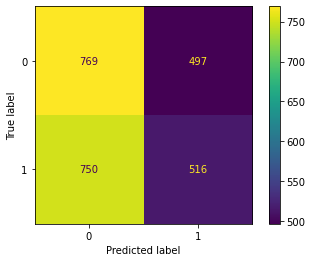

In [209]:
# Confusion matrix for test set Guangzhou

confusion_matrix_guangzhou = metrics.confusion_matrix(Y_test_oversampled_guangzhou, predicted_y_guangzhou)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_guangzhou, display_labels = [0, 1])

cm_display.plot()
plt.show()

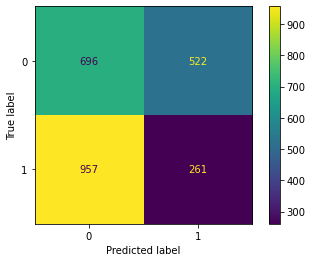

In [210]:
# Confusion matrix for test set Shanghai

confusion_matrix_shanghai = metrics.confusion_matrix(Y_test_oversampled_shanghai, predicted_y_shanghai)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_shanghai, display_labels = [0, 1])

cm_display.plot()
plt.show()

**Comparing with logistic regression and KNN**\
We are examining the performances of the models logistic regression and KNN, to be able to compare the performance of our model. 


In [211]:
lgr = LogisticRegression()
lgr.fit(X_train_scaled, Y_train)
lgr_score = lgr.score(X_test_scaled_shanghai, Y_test_oversampled_shanghai)
lgr_predictions = lgr.predict(X_test_scaled_shanghai)
f1_lgr = f1_score(Y_test_oversampled_shanghai, lgr_predictions)
print(f'Accuracy score of logistic regression for test set Shanghai: {round(lgr_score, 4)}')
print(f'F1 Score of logistic regression for test set Shanghai: {round(f1_lgr, 4)} \n')

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, Y_train)
knn_score = knn.score(X_test_scaled_shanghai, Y_test_oversampled_shanghai)
knn_predictions = knn.predict(X_test_scaled_shanghai)
f1_knn = f1_score(Y_test_oversampled_shanghai, knn_predictions)
print('Accuracy score of KNN Classifier for test set Shanghai:', round(knn_score, 4))
print('F1 score of KNN Classifier for test set Shanghai:', round(f1_knn, 4))

Accuracy score of logistic regression for test set Shanghai: 0.4573
F1 Score of logistic regression for test set Shanghai: 0.4302 

Accuracy score of KNN Classifier for test set Shanghai: 0.5378
F1 score of KNN Classifier for test set Shanghai: 0.6149


In [212]:
lgr = LogisticRegression()
lgr.fit(X_train_scaled, Y_train)
lgr_score = lgr.score(X_test_scaled_guangzhou, Y_test_oversampled_guangzhou)
lgr_predictions = lgr.predict(X_test_scaled_guangzhou)
f1_lgr = f1_score(Y_test_oversampled_guangzhou, lgr_predictions)
print('Accuracy score of logistic regression for test set Guangzhou:', round(lgr_score, 4))
print(f'F1 Score of logistic regression for test set Guangzhou: {round(f1_lgr, 4)} \n')

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, Y_train)
knn_score = knn.score(X_test_scaled_guangzhou, Y_test_oversampled_guangzhou)
knn_predictions = knn.predict(X_test_scaled_guangzhou)
f1_knn = f1_score(Y_test_oversampled_guangzhou, knn_predictions)
print('Accuracy score of KNN Classifier for test set Guangzhou:', round(knn_score, 4))
print('F1 score of KNN Classifier for test set Guangzhou:', round(f1_knn, 4))

Accuracy score of logistic regression for test set Guangzhou: 0.5296
F1 Score of logistic regression for test set Guangzhou: 0.5733 

Accuracy score of KNN Classifier for test set Guangzhou: 0.481
F1 score of KNN Classifier for test set Guangzhou: 0.5761
